# import Libraries

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from keras.layers import Input
from keras.layers import Dropout
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dropout
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [5]:
import numpy as np
import tensorflow as tf

print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)


NumPy version: 1.26.4
TensorFlow version: 2.17.0


# Load data

In [6]:
data=pd.read_parquet('BTC_USDT_ohlcv_data.parquet')


# turn data to csv

In [7]:
data.to_csv('BTC_USDT_ohlcv_data.csv', index=False)

In [64]:
df=pd.read_csv('BTC_USDT_ohlcv_data.csv')

In [65]:
# show the data
df.head()

,timestamp,open,high,low,close,volume
0,2017-08-17 12:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
1,2017-08-17 12:15:00,4261.48,4270.41,4261.32,4261.45,9.119865
2,2017-08-17 12:30:00,4280.00,4310.07,4267.99,4310.07,21.923552
3,2017-08-17 12:45:00,4310.07,4313.62,4291.37,4308.83,13.948531
4,2017-08-17 13:00:00,4308.83,4328.69,4304.31,4304.31,5.101153


In [66]:
# the shape of data

df.shape

(258143, 6)

In [67]:
# the info of data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258143 entries, 0 to 258142
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  258143 non-null  object 
 1   open       258143 non-null  float64
 2   high       258143 non-null  float64
 3   low        258143 non-null  float64
 4   close      258143 non-null  float64
 5   volume     258143 non-null  float64
dtypes: float64(5), object(1)
memory usage: 11.8+ MB


In [68]:
# show description of data
df.describe()

,open,high,low,close,volume
count,258143.000000,258143.000000,258143.000000,258143.000000,258143.000000
mean,27060.139201,27121.911523,26995.972207,27060.478933,710.798484
std,22081.846645,22125.717193,22036.095440,22082.217483,1118.403445
min,2830.000000,2880.010000,2817.000000,2820.000000,0.000000
25%,8529.020000,8551.930000,8504.010000,8529.610000,201.383259
50%,20202.230000,20245.580000,20155.540000,20202.240000,368.692688
75%,42031.725000,42129.360000,41934.025000,42031.990000,740.296709
max,108258.380000,108353.000000,107721.800000,108258.390000,40371.405060


In [69]:
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.date

In [70]:
df.head()

,timestamp,open,high,low,close,volume
0,2017-08-17,4261.48,4280.56,4261.48,4261.48,2.189061
1,2017-08-17,4261.48,4270.41,4261.32,4261.45,9.119865
2,2017-08-17,4280.00,4310.07,4267.99,4310.07,21.923552
3,2017-08-17,4310.07,4313.62,4291.37,4308.83,13.948531
4,2017-08-17,4308.83,4328.69,4304.31,4304.31,5.101153


In [71]:
# turn the datatime to datetime as date

df['date'] = pd.to_datetime(df['timestamp'])

In [72]:
# show the number of years in the data

print("Years:", df['date'].dt.year.nunique())

Years: 9


In [76]:
# check for missing values,dublicates and uniques 

info = pd.DataFrame(df.isna().sum(), columns=["IsNa"])
info.insert(1, "Duplicate", df.duplicated().sum(), True)
info.insert(2, "Unique", df.nunique(),True)
info.T

,timestamp,open,high,low,close,volume
IsNa,0,0,0,0,0,0
Duplicate,13,13,13,13,13,13
Unique,2696,237967,212812,215187,236594,257999


In [77]:
df.drop_duplicates(inplace=True)

In [78]:
info = pd.DataFrame(df.isna().sum(), columns=["IsNa"])
info.insert(1, "Duplicate", df.duplicated().sum(), True)
info.insert(2, "Unique", df.nunique(),True)
info.T

,timestamp,open,high,low,close,volume
IsNa,0,0,0,0,0,0
Duplicate,0,0,0,0,0,0
Unique,2696,237967,212812,215187,236594,257999


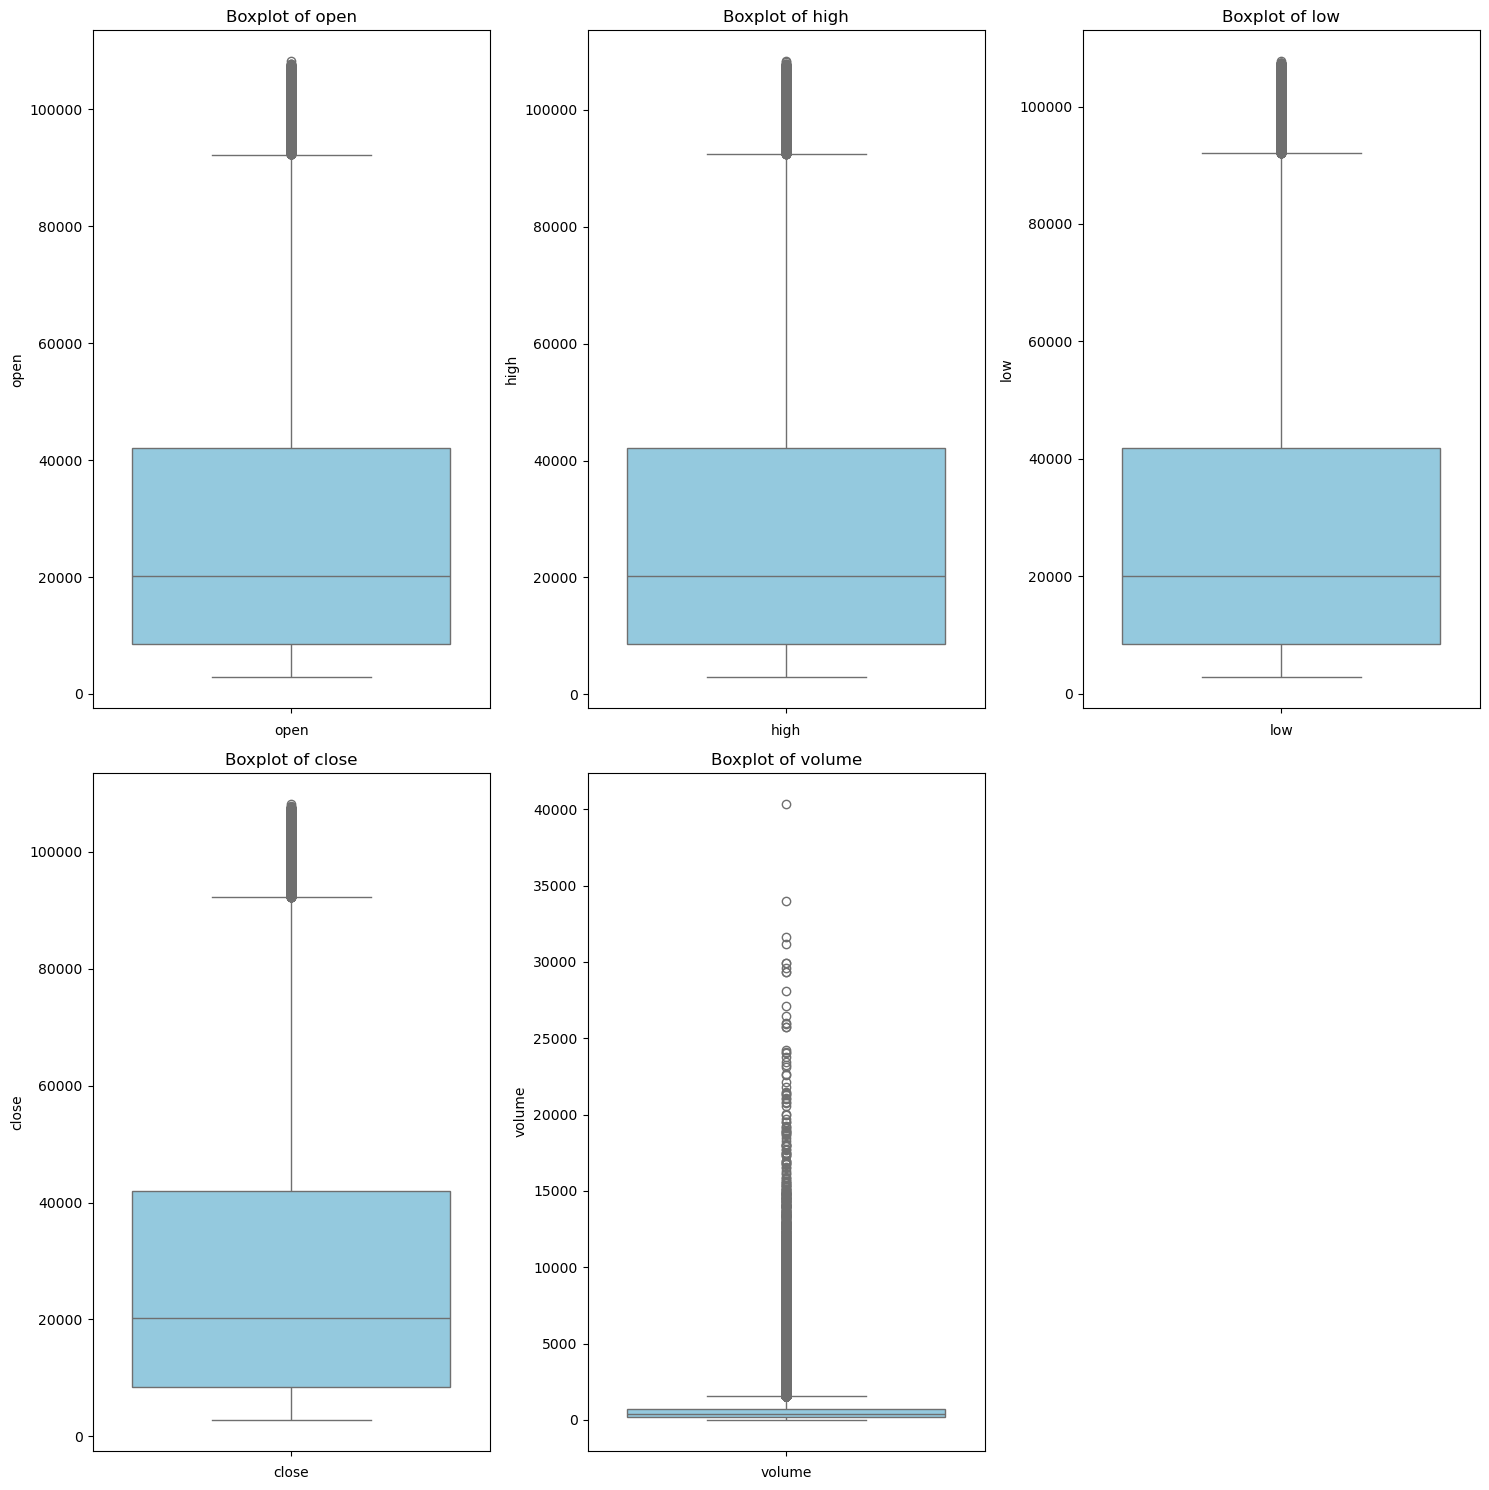

In [79]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
fig, axes = plt.subplots(len(numeric_columns) // 3 + 1, 3, figsize=(15, 15))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(y=df[column], ax=axes[i], color='skyblue') 
    axes[i].set_title(f'Boxplot of {column}', fontsize=12)
    axes[i].set_xlabel(column, fontsize=10)

    # Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [80]:
def get_outliers_info(df):
    outliers_dict = {}

    numeric_cols = df.select_dtypes(include=np.number).columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outlier_rows = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        print(f"\nColumn: {col}")
        print(f"  Lower Bound: {lower_bound}")
        print(f"  Upper Bound: {upper_bound}")
        print(f"  Outliers Found: {len(outlier_rows)}")

        outliers_dict[col] = {
            'lower_bound': lower_bound,        
            'upper_bound': upper_bound,
            'num_outliers': len(outlier_rows),
            'outlier_rows': outlier_rows
        }

    return outliers_dict


In [81]:
outliers_result = get_outliers_info(df)


Column: open
  Lower Bound: -41724.03125
  Upper Bound: 92284.67874999999
  Outliers Found: 4101

Column: high
  Lower Bound: -41813.76875
  Upper Bound: 92495.06125
  Outliers Found: 4103

Column: low
  Lower Bound: -41640.69124999999
  Upper Bound: 92078.81874999998
  Outliers Found: 4095

Column: close
  Lower Bound: -41723.682499999995
  Upper Bound: 92285.17749999999
  Outliers Found: 4102

Column: volume
  Lower Bound: -606.9708304999999
  Upper Bound: 1548.6898975
  Outliers Found: 27557


In [82]:
df.head()

,timestamp,open,high,low,close,volume
date,,,,,,
2017-08-17,2017-08-17,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17,2017-08-17,4400.00,4419.00,4400.00,4415.00,2.078235
2017-08-17,2017-08-17,4419.00,4470.00,4419.00,4460.00,17.512833
2017-08-17,2017-08-17,4460.00,4474.80,4454.72,4474.80,16.084544
2017-08-17,2017-08-17,4474.80,4485.39,4465.06,4485.39,8.844785


In [83]:
df.reset_index(inplace=True)


In [84]:
df.drop(['timestamp'],axis=1,inplace=True)

In [85]:
df.head()

,date,open,high,low,close,volume
0,2017-08-17,4261.48,4280.56,4261.48,4261.48,2.189061
1,2017-08-17,4400.00,4419.00,4400.00,4415.00,2.078235
2,2017-08-17,4419.00,4470.00,4419.00,4460.00,17.512833
3,2017-08-17,4460.00,4474.80,4454.72,4474.80,16.084544
4,2017-08-17,4474.80,4485.39,4465.06,4485.39,8.844785


In [86]:
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

# data Visualization

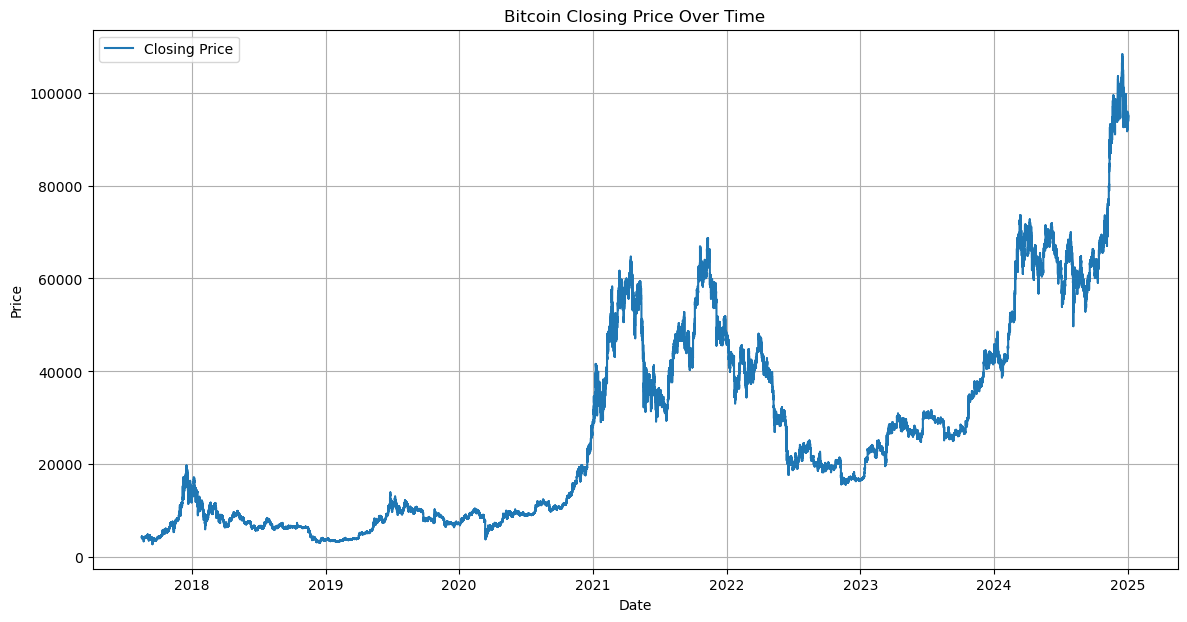

In [87]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Closing Price', color='tab:blue')
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

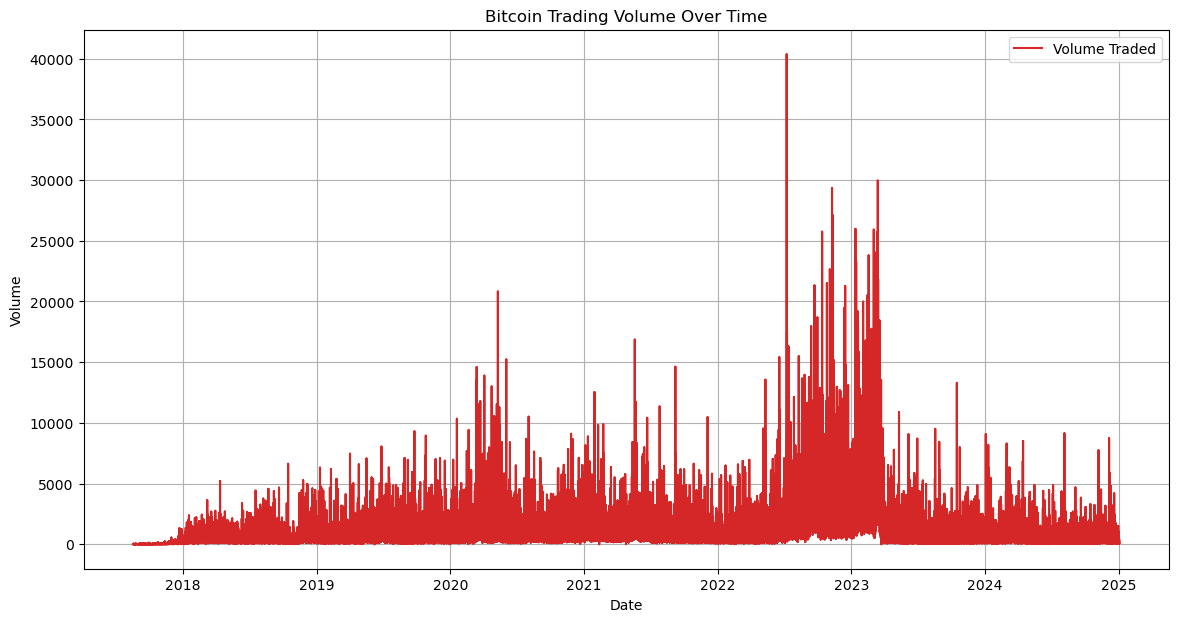

In [88]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['volume'], label='Volume Traded', color='tab:red')
plt.title('Bitcoin Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

# data Preprocessing

In [89]:
target_col = 'close'

In [90]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [91]:
scaled.head()

,open,high,low,close,volume
date,,,,,
2017-08-17,0.013578,0.013279,0.013769,0.013671,0.000054
2017-08-17,0.015309,0.014828,0.015509,0.015402,0.000001
2017-08-17,0.013578,0.013183,0.013768,0.013671,0.000226
2017-08-17,0.013753,0.013559,0.013831,0.014132,0.000543
2017-08-17,0.014039,0.013592,0.014054,0.014120,0.000346


In [92]:
X = scaled.drop(columns=[target_col])  
y = scaled[target_col]

In [93]:
window_size = 30
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])  
        y.append(target[i]) 
    return np.array(X), np.array(y)

In [94]:
X, y = create_sequences(X.values, y.values, window_size)

In [95]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)

In [96]:
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (165184, 30, 4)
X_val shape: (41296, 30, 4)
X_test shape: (51620, 30, 4)
y_train shape: (165184,)
y_val shape: (41296,)


In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])  #window size, num of features

In [98]:
# Fit and evaluate function
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):

    # Fit the model with EarlyStopping
    history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                        validation_data=(X_val, y_val))

    # Evaluate loss
    test_loss = model.evaluate(X_test, y_test)
    val_loss = model.evaluate(X_val, y_val)

    # Predict
    y_pred = model.predict(X_test)
    y_val_pred = model.predict(X_val)

    # R² scores
    r2_test = r2_score(y_test, y_pred)
    r2_val = r2_score(y_val, y_val_pred)

    return r2_test, r2_val, test_loss, val_loss

In [ ]:

def build_cnn(input_shape):
    model = Sequential()
    
    model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=input_shape))

    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2)) 
    
    model.add(Conv1D(256, kernel_size=3, activation='relu'))
    
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))  

    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  
    
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

    
    return model

In [100]:
cnn_model = build_cnn(input_shape)

c:\Users\mahcb\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [101]:
cnn_r2_test, cnn_r2_val, cnn_loss_test, cnn_loss_val = evaluate_model(cnn_model, X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 75s 14ms/step - loss: 0.0015 - val_loss: 1.6239e-04
Epoch 2/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 60s 12ms/step - loss: 7.0905e-04 - val_loss: 8.1654e-05
Epoch 3/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - loss: 6.8952e-04 - val_loss: 2.1787e-04
Epoch 4/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 74s 14ms/step - loss: 6.7828e-04 - val_loss: 3.9301e-05
Epoch 5/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 73s 14ms/step - loss: 6.6243e-04 - val_loss: 2.8678e-04
Epoch 6/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 73s 14ms/step - loss: 6.7606e-04 - val_loss: 1.1591e-04
Epoch 7/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - loss: 6.6900e-04 - val_loss: 2.5583e-04
Epoch 8/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - loss: 6.6216e-04 - val_loss: 5.9296e-04
Epoch 9/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 69s 13ms/step - loss: 6.6836e-04 - val_loss: 9.1826e-04
Epoch 10/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 68s 13ms/step - loss: 6.6015e-04 - val_loss: 5.6497e-04
1614/1614 ━━━━━━━━━━━━━

In [102]:
print(f'CNN - R2 Test: {cnn_r2_test}, R2 Val: {cnn_r2_val}, Test Loss: {cnn_loss_test}, Val Loss: {cnn_loss_val}')

CNN - R2 Test: 0.936021877208116, R2 Val: 0.692698412509531, Test Loss: 0.0023355199955403805, Val Loss: 0.0005649701342917979


In [103]:
import joblib
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [104]:
joblib.dump(cnn_model,'btc_cnn_model.pkl')

['btc_cnn_model.pkl']

In [ ]:
def build_lstm(input_shape):
    model = Sequential()

    model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  

    model.add(LSTM(100, activation='tanh', return_sequences=False))
    model.add(Dropout(0.3))  

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5)) 

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    

    return model

In [106]:
lstm_model = build_lstm(input_shape)

c:\Users\mahcb\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [107]:
lstm_r2_test, lstm_r2_val, lstm_loss_test, lstm_loss_val = evaluate_model(lstm_model, X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 239s 45ms/step - loss: 0.0013 - val_loss: 1.5896e-05
Epoch 2/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 224s 43ms/step - loss: 6.2661e-04 - val_loss: 4.3711e-05
Epoch 3/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 237s 46ms/step - loss: 5.7191e-04 - val_loss: 4.2365e-05
Epoch 4/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 258s 50ms/step - loss: 5.6325e-04 - val_loss: 1.8586e-04
Epoch 5/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 249s 48ms/step - loss: 5.4923e-04 - val_loss: 7.7269e-05
Epoch 6/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 238s 46ms/step - loss: 5.3010e-04 - val_loss: 2.9029e-05
Epoch 7/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 276s 53ms/step - loss: 5.2919e-04 - val_loss: 3.2027e-05
Epoch 8/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 265s 51ms/step - loss: 5.1954e-04 - val_loss: 4.2870e-05
Epoch 9/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 248s 48ms/step - loss: 5.3226e-04 - val_loss: 4.0450e-05
Epoch 10/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 238s 46ms/step - loss: 5.2009e-04 - val_loss: 2.3826e-04
1614/1614 ━━━

In [112]:
print(f'LSTM - R2 Test: {lstm_r2_test}, R2 Val: {lstm_r2_val}, Test Loss: {lstm_loss_test}, Val Loss: {lstm_loss_val}')

LSTM - R2 Test: 0.9105404650146388, R2 Val: 0.870405382318031, Test Loss: 0.0032657193951308727, Val Loss: 0.0002382580132689327


In [126]:
lstm_model.save('btc_lstm_model.h5')

In [ ]:
def build_gru(input_shape):
    model = Sequential()

    
    model.add(GRU(100, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  

    
    model.add(GRU(100, activation='relu', return_sequences=False))
    model.add(Dropout(0.3)) 

    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(1))

    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model

In [109]:
gru_model = build_gru(input_shape)

c:\Users\mahcb\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [111]:
gru_r2_test, gru_r2_val, gru_loss_test, gru_loss_val = evaluate_model(gru_model, X_train, y_train, X_val, y_val,X_test,y_test)

Epoch 1/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 263s 50ms/step - loss: 0.0015 - val_loss: 9.0238e-05
Epoch 2/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 259s 50ms/step - loss: 5.0836e-04 - val_loss: 2.0373e-04
Epoch 3/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 289s 56ms/step - loss: 4.6519e-04 - val_loss: 5.3488e-05
Epoch 4/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 271s 53ms/step - loss: 4.5973e-04 - val_loss: 1.0972e-04
Epoch 5/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 287s 56ms/step - loss: 4.5833e-04 - val_loss: 4.2238e-04
Epoch 6/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 299s 58ms/step - loss: 4.5016e-04 - val_loss: 3.4157e-04
Epoch 7/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 270s 52ms/step - loss: 4.3679e-04 - val_loss: 2.2994e-04
Epoch 8/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 281s 54ms/step - loss: 4.4060e-04 - val_loss: 8.5929e-04
Epoch 9/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 285s 55ms/step - loss: 4.2897e-04 - val_loss: 2.0766e-04
Epoch 10/10
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 300s 58ms/step - loss: 4.3932e-04 - val_loss: 4.8265e-04
1614/1614 ━━━

In [127]:
gru_model.save('btc_gru_model.h5')

In [114]:
print(f'CNN - R2 Test: {cnn_r2_test}, R2 Val: {cnn_r2_val}, Test Loss: {cnn_loss_test}, Val Loss: {cnn_loss_val}')
print(f'LSTM - R2 Test: {lstm_r2_test}, R2 Val: {lstm_r2_val}, Test Loss: {lstm_loss_test}, Val Loss: {lstm_loss_val}')
print(f'GRU - R2 Test: {gru_r2_test}, R2 Val: {gru_r2_val}, Test Loss: {gru_loss_test}, Val Loss: {gru_loss_val}')

CNN - R2 Test: 0.936021877208116, R2 Val: 0.692698412509531, Test Loss: 0.0023355199955403805, Val Loss: 0.0005649701342917979
LSTM - R2 Test: 0.9105404650146388, R2 Val: 0.870405382318031, Test Loss: 0.0032657193951308727, Val Loss: 0.0002382580132689327
GRU - R2 Test: 0.8616369626629934, R2 Val: 0.7374764007868563, Test Loss: 0.005050939042121172, Val Loss: 0.0004826467193197459


In [117]:
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import VotingRegressor

In [118]:
lstm_reg = KerasRegressor(model=build_lstm, model__input_shape=input_shape, epochs=20, batch_size=32, verbose=0)
gru_reg = KerasRegressor(model=build_gru, model__input_shape=input_shape, epochs=20, batch_size=32, verbose=0)

In [119]:
ensemble = VotingRegressor(estimators=[
    ('lstm', lstm_reg),
    ('gru', gru_reg)
])


In [120]:
ensemble.fit(X_train, y_train)

c:\Users\mahcb\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\mahcb\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


VotingRegressor(estimators=[('lstm',
                             KerasRegressor(batch_size=32, epochs=20, model=<function build_lstm at 0x0000023FA6DE9B20>, model__input_shape=(30, 4), verbose=0)),
                            ('gru',
                             KerasRegressor(batch_size=32, epochs=20, model=<function build_gru at 0x0000023F99C26A20>, model__input_shape=(30, 4), verbose=0))])

In [124]:
from sklearn.metrics import mean_squared_error
ensemble_preds = ensemble.predict(X_test)
r2 = r2_score(y_test, ensemble_preds)
mse = mean_squared_error(y_test, ensemble_preds)

print("R² Score:", r2)
print("MSE:", mse)

R² Score: 0.9667106067058943
MSE: 0.0012152285832802375


In [125]:
joblib.dump(ensemble,'btc_voting_model.pkl')

['btc_voting_model.pkl']